# Metcalfe's Law and Bitcoin Price


The aim of this notebook is provide BTC price range estimate based the the amount of BTC wallets using [Metcalfe's Law](https://en.wikipedia.org/wiki/Metcalfe%27s_law).

According to [Metcalfe's Law](https://en.wikipedia.org/wiki/Metcalfe%27s_law) a value of networks (fully deluted market cap) is proportinal to the number of possible connection between their participants (wallets). As each partcipant can have _n-1_ connection, the value of the network, not cosidering the cost of the network, is :

> V=An(n-1)/2

If n is large and k=A/2 :

> V = k * n^2

_n_ is equated to the number of BTC addresses (_addressesCount_) holding more than certain amount of BTC (0.1/0.01/0.001)


In [1]:
import requests
import json
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from datetime import datetime
import time

# ----- User Settings 

collectDataFrom = pd.Timestamp('2016-01-01')

# cryptocompare.com API Key
cryptocompare_api_key = '777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49'

# Having more or same BTC as [x,y,z]. This is for filtering out empty wallets
min_btcs =  [0.001] 
# Reuqested Simple Moving Averages for calucating k
smas = [7,30,90,180, 365]
# ----- User Settings -- end

coins=['BTC']  # Only BTC is available at cryptocompare



requestUrls = ['https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym={}&api_key={}&toTs={}&limit={}',
              'https://min-api.cryptocompare.com/data/v2/histoday?fsym={}&tsym=USD&api_key={}&toTs={}&limit={}']


limit=2000
coin_dfs=[]
for coin in coins:
    time_segments = []
    timestamp = pd.Timestamp.now()
    while collectDataFrom <= timestamp : 
        segment_dfs = []
        for requestUrl in requestUrls:
            segment_df = pd.DataFrame()
            requestUrl = requestUrl.format(coin, cryptocompare_api_key, timestamp.timestamp(),limit)
            # print("Request : " + requestUrl)    
            response = requests.get(requestUrl).text 
            parsed = json.loads(response)
            # print("Json : \n\n" + response)
            segment_df = pd.DataFrame(parsed['Data']['Data'])
            segment_df['time'] = pd.to_datetime(segment_df['time'], unit='s')
            segment_df.set_index(['time'],inplace=True, verify_integrity = True, drop = True)
            segment_df.sort_index(inplace=True)
            segment_dfs.append(segment_df)
        
        #segment_df.drop_duplicates(inplace=True)
        concated_segment_dfs= pd.concat(segment_dfs,axis=1)
        time_segments.append(concated_segment_dfs) 
        
        timestamp = segment_df.first_valid_index() - pd.Timedelta(1, "d") # -1 day    
        concated_segment_dfs.drop(columns=['volumefrom','volumeto','conversionType'
                                           ,'conversionSymbol', 'open','high','low'
                                           ,'id','symbol','partner_symbol'], inplace=True)
        #print("seg tail {}".format(concated_segment_dfs.tail(1)))

    df = pd.concat(time_segments, axis=0)
    df.sort_index(inplace=True)
    # print("Df {}\n".format(df))    
    df.dropna(inplace=True)
    df_wallet_ranges = [] 
    for i in range(10):
        df_wallet_range = pd.DataFrame()
        df_wallet_range['addressesCount'] = df['balance_distribution'].map(lambda x: x[i]['addressesCount'])
        df_wallet_range['totalVolume'] = df['balance_distribution'].map(lambda x: x[i]['totalVolume'])
        vindex= df.first_valid_index()  
        range_name = "{}-{}".format(df.loc[vindex,['balance_distribution']][0][i]['from'], 
                                    df.loc[vindex,['balance_distribution']][0][i]['to'])
        df_wallet_range =  pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
        df_wallet_ranges.append(df_wallet_range)
    range_name = "all"
    df_wallet_range = pd.DataFrame()
    df_wallet_range['price'] = df['close']
    df_wallet_range = pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
    df_wallet_ranges.append(df_wallet_range)
    
    df = pd.concat(df_wallet_ranges, axis=1)
 
    df = pd.concat({coin: df}, axis=1, names=["coin", "wallet_range", "metrics"])
    coin_dfs.append(df)
df=pd.concat(coin_dfs, axis=1)
df=df.loc[collectDataFrom:]
df.sort_index(inplace=True)
df

coin                    BTC                                            \
wallet_range    1e-08-0.001                  0.001-0.01                 
metrics      addressesCount  totalVolume addressesCount   totalVolume   
time                                                                    
2016-01-01          3665226   578.938673        1085901   3871.206704   
2016-01-02          3671916   579.758631        1087430   3878.231242   
2016-01-03          3679706   582.047421        1094116   3898.193644   
2016-01-04          3678465   581.180838        1096611   3910.677452   
2016-01-05          3685366   582.648136        1098730   3918.410351   
...                     ...          ...            ...           ...   
2023-04-16         23695529  4837.282201       10512595  39340.131139   
2023-04-17         23672124  4817.821366       10499779  39289.253016   
2023-04-18         23505702  4734.957732       10480643  39226.689456   
2023-04-19         23468608  4721.064134       10489060  39269.951837   
2023-04-20         23471503  4723.722103       10494183  39310.666363   

coin                                                                     \
wallet_range       0.01-0.1                         0.1-1                 
metrics      addressesCount    totalVolume addressesCount   totalVolume   
time                                                                      
2016-01-01          1169255   36872.042152         707940  2.482463e+05   
2016-01-02          1142428   36764.224213         711123  2.491854e+05   
2016-01-03          1145311   36842.919032         713516  2.499354e+05   
2016-01-04          1149919   36995.866074         716899  2.510780e+05   
2016-01-05          1149566   36959.161953         717065  2.510457e+05   
...                     ...            ...            ...           ...   
2023-04-16          7429957  250373.040880        3313536  1.030728e+06   
2023-04-17          7432306  250495.588423        3314576  1.030983e+06   
2023-04-18          7433307  250610.449263        3316439  1.031472e+06   
2023-04-19          7445250  250930.622887        3317911  1.031727e+06   
2023-04-20          7457229  251320.598589        3319299  1.032029e+06   

coin                                       ...                               \
wallet_range           1-10                ...        10-100       100-1000   
metrics      addressesCount   totalVolume  ...   totalVolume addressesCount   
time                                       ...                                
2016-01-01           376567  9.916883e+05  ...  2.685810e+06          14830   
2016-01-02           377007  9.924879e+05  ...  2.685658e+06          14853   
2016-01-03           377305  9.928665e+05  ...  2.686400e+06          14846   
2016-01-04           377699  9.927550e+05  ...  2.686812e+06          14846   
2016-01-05           377014  9.905627e+05  ...  2.684720e+06          14927   
...                     ...           ...  ...           ...            ...   
2023-04-16           838004  2.091588e+06  ...  4.438141e+06          13788   
2023-04-17           838108  2.091852e+06  ...  4.437044e+06          13854   
2023-04-18           838104  2.091550e+06  ...  4.435891e+06          13860   
2023-04-19           838046  2.091232e+06  ...  4.435710e+06          13868   
2023-04-20           837985  2.091474e+06  ...  4.435697e+06          13873   

coin                                                                    \
wallet_range                   1000-10000                 10000-100000   
metrics        totalVolume addressesCount   totalVolume addressesCount   
time                                                                     
2016-01-01    3.357387e+06           1629  3.304007e+06            101   
2016-01-02    3.356210e+06           1631  3.307030e+06            101   
2016-01-03    3.353995e+06           1629  3.305562e+06            101   
2016-01-04    3.355247e+06           1631  3.309012e+06            101   


In [2]:
df_aux = pd.DataFrame()

coin = 'BTC'

#aggregate_wallets=['0.1-1','1-10', '10-100','100-1000', '1000-10000', '10000-100000', '100000-1000000']
aggregate_wallets=['1-10', '10-100','100-1000', '1000-10000', '10000-100000']


#aggregate_wallets.append('1-10')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'1+','addressesCount')] = df_aux['addressesCount']

aggregate_wallets.append('0.1-1')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.1+','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('0.01-0.1')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.01+','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('0.001-0.01')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.001+','addressesCount')] = df_aux['addressesCount']
#df.drop(columns=['100000-0','1e-08-0.001',*aggregate_wallets],inplace=True,level= "wallet_range")
df.drop(columns=['1e-08-0.001',*aggregate_wallets],inplace=True,level= "wallet_range")


df

coin                    BTC                                          \
wallet_range       100000-0                      all             1+   
metrics      addressesCount    totalVolume     price addressesCount   
time                                                                  
2016-01-01                2  325228.141841    433.99         487725   
2016-01-02                2  325228.141841    433.72         488157   
2016-01-03                2  325228.141841    430.70         488369   
2016-01-04                2  325228.143333    433.32         488813   
2016-01-05                2  325228.143333    431.20         488080   
...                     ...            ...       ...            ...   
2023-04-16                4  673305.936238  30322.77         993903   
2023-04-17                4  673305.936351  29446.77         994057   
2023-04-18                4  673305.936351  30396.77         994038   
2023-04-19                4  673305.936351  28828.20         994034   
2023-04-20                4  673305.936351  28245.06         993907   

coin                                                       
wallet_range           0.1+          0.01+         0.001+  
metrics      addressesCount addressesCount addressesCount  
time                                                       
2016-01-01          1195665        2364920        3450821  
2016-01-02          1199280        2341708        3429138  
2016-01-03          1201885        2347196        3441312  
2016-01-04          1205712        2355631        3452242  
2016-01-05          1205145        2354711        3453441  
...                     ...            ...            ...  
2023-04-16          4307439       11737396       22249991  
2023-04-17          4308633       11740939       22240718  
2023-04-18          4310477       11743784       22224427  
2023-04-19          4311945       11757195       22246255  
2023-04-20          4313206       11770435       22264618  

[2667 rows x 7 columns]

In [3]:
import nasdaqdatalink

def convert_to_m2(df,dt):
    iloc_idx = df.index.get_indexer([dt], method='nearest')  # returns absolute index into df e.g. array([5])
    loc_idx = df.index[iloc_idx]                             # if you want named index
    return df.loc[loc_idx,'Value'].values[0] 
token = 'JEn6xy3nc1JtFSLoXoVJ'
wm2ns = nasdaqdatalink.get("FED/M2_N_WM", authtoken=token)    
df_m2 = pd.DataFrame(wm2ns)
#df_m2 = pd.read_csv('data/WM2NS.csv')
#df_m2['Date']= pd.to_datetime(df_m2['Date'])


In [4]:

#df_m2.set_index(['Date'],inplace=True, verify_integrity = True, drop = True)
df.loc(axis=1)[('USD','all', 'm2_supply')] = df.index.map(lambda dt: convert_to_m2(df_m2,dt))

btc_birthday = pd.to_datetime('2009-01-03')
m2_supply_at_genesis = convert_to_m2(df_m2,btc_birthday)
df.loc(axis=1)[('USD','all', 'm2_supply_index')] = df.loc(axis=1)[('USD','all', 'm2_supply')]/m2_supply_at_genesis
df.loc(axis=1)[('BTC','all', 'm2_adj_price')] = df.loc(axis=1)[('BTC','all', 'price')] /df.loc(axis=1)[('USD','all', 'm2_supply_index')]
df

coin                    BTC                                          \
wallet_range       100000-0                      all             1+   
metrics      addressesCount    totalVolume     price addressesCount   
time                                                                  
2016-01-01                2  325228.141841    433.99         487725   
2016-01-02                2  325228.141841    433.72         488157   
2016-01-03                2  325228.141841    430.70         488369   
2016-01-04                2  325228.143333    433.32         488813   
2016-01-05                2  325228.143333    431.20         488080   
...                     ...            ...       ...            ...   
2023-04-16                4  673305.936238  30322.77         993903   
2023-04-17                4  673305.936351  29446.77         994057   
2023-04-18                4  673305.936351  30396.77         994038   
2023-04-19                4  673305.936351  28828.20         994034   
2023-04-20                4  673305.936351  28245.06         993907   

coin                                                            USD  \
wallet_range           0.1+          0.01+         0.001+       all   
metrics      addressesCount addressesCount addressesCount m2_supply   
time                                                                  
2016-01-01          1195665        2364920        3450821   12459.0   
2016-01-02          1199280        2341708        3429138   12459.0   
2016-01-03          1201885        2347196        3441312   12459.0   
2016-01-04          1205712        2355631        3452242   12459.0   
2016-01-05          1205145        2354711        3453441   12459.0   
...                     ...            ...            ...       ...   
2023-04-16          4307439       11737396       22249991   21123.3   
2023-04-17          4308633       11740939       22240718   21123.3   
2023-04-18          4310477       11743784       22224427   21123.3   
2023-04-19          4311945       11757195       22246255   21123.3   
2023-04-20          4313206       11770435       22264618   21123.3   

coin                                   BTC  
wallet_range                           all  
metrics      m2_supply_index  m2_adj_price  
time                                        
2016-01-01          1.501175    289.100249  
2016-01-02          1.501175    288.920390  
2016-01-03          1.501175    286.908632  
2016-01-04          1.501175    288.653932  
2016-01-05          1.501175    287.241705  
...                      ...           ...  
2023-04-16          2.545129  11914.039455  
2023-04-17          2.545129  11569.852609  
2023-04-18          2.545129  11943.114599  
2023-04-19          2.545129  11326.811904  
2023-04-20          2.545129  11097.691908  

[2667 rows x 10 columns]

In [5]:

btc_max_supply = 21*10**6
for min_btc in min_btcs:
    df.loc(axis=1)[(coin,str(min_btc) + '+','k')] = btc_max_supply*df.loc(axis=1)[(coin,'all','m2_adj_price')] \
        / ( df.loc(axis=1)[(coin, str(min_btc) + '+','addressesCount')] \
        * df.loc(axis=1)[(coin, str(min_btc) + '+','addressesCount')])
    for days in smas: 
        df.loc(axis=1)[(coin, str(min_btc) + '+', 'k-sma' + str(days) +'d')] = \
            df.loc(axis=1)[(coin, str(min_btc) + '+','k')].rolling(days).mean()

# df=df.loc['2013-01-01':]
df

coin                    BTC                                          \
wallet_range       100000-0                      all             1+   
metrics      addressesCount    totalVolume     price addressesCount   
time                                                                  
2016-01-01                2  325228.141841    433.99         487725   
2016-01-02                2  325228.141841    433.72         488157   
2016-01-03                2  325228.141841    430.70         488369   
2016-01-04                2  325228.143333    433.32         488813   
2016-01-05                2  325228.143333    431.20         488080   
...                     ...            ...       ...            ...   
2023-04-16                4  673305.936238  30322.77         993903   
2023-04-17                4  673305.936351  29446.77         994057   
2023-04-18                4  673305.936351  30396.77         994038   
2023-04-19                4  673305.936351  28828.20         994034   
2023-04-20                4  673305.936351  28245.06         993907   

coin                                                            USD  \
wallet_range           0.1+          0.01+         0.001+       all   
metrics      addressesCount addressesCount addressesCount m2_supply   
time                                                                  
2016-01-01          1195665        2364920        3450821   12459.0   
2016-01-02          1199280        2341708        3429138   12459.0   
2016-01-03          1201885        2347196        3441312   12459.0   
2016-01-04          1205712        2355631        3452242   12459.0   
2016-01-05          1205145        2354711        3453441   12459.0   
...                     ...            ...            ...       ...   
2023-04-16          4307439       11737396       22249991   21123.3   
2023-04-17          4308633       11740939       22240718   21123.3   
2023-04-18          4310477       11743784       22224427   21123.3   
2023-04-19          4311945       11757195       22246255   21123.3   
2023-04-20          4313206       11770435       22264618   21123.3   

coin                                   BTC                                \
wallet_range                           all    0.001+                       
metrics      m2_supply_index  m2_adj_price         k   k-sma7d  k-sma30d   
time                                                                       
2016-01-01          1.501175    289.100249  0.000510       NaN       NaN   
2016-01-02          1.501175    288.920390  0.000516       NaN       NaN   
2016-01-03          1.501175    286.908632  0.000509       NaN       NaN   
2016-01-04          1.501175    288.653932  0.000509       NaN       NaN   
2016-01-05          1.501175    287.241705  0.000506       NaN       NaN   
...                      ...           ...       ...       ...       ...   
2023-04-16          2.545129  11914.039455  0.000505  0.000501  0.000470   
2023-04-17          2.545129  11569.852609  0.000491  0.000501  0.000471   
2023-04-18          2.545129  11943.114599  0.000508  0.000503  0.000473   
2023-04-19          2.545129  11326.811904  0.000481  0.000500  0.000473   
2023-04-20          2.545129  11097.691908  0.000470  0.000495  0.000473   

coin                                        
wallet_range                                
metrics       k-sma90d k-sma180d k-sma365d  
time                                        
2016-01-01         NaN       NaN       NaN  
2016-01-02         NaN       NaN       NaN  
2016-01-03         NaN       NaN       NaN  
2016-01-04         NaN       NaN       NaN  
2016-01-05         NaN       NaN       NaN  
...                ...       ...       ...  
2023-04-16    0.000420  0.000364  0.000412  
2023-04-17    0.000422  0.000365  0.000412  
2023-04-18    0.000423  0.000366  0.000411  
2023-04-19    0.000425  0.000367  0.000410  
2023-04-20    0.000425  0.000367  0.000409  

[2667 rows x 16 columns]

In [6]:
ranges_from_sma_days = 30

for min_btc in min_btcs:
    wallet_range = str(min_btc) + '+'
    k_btc_bottom = df['BTC',wallet_range,'k-sma'+ str(ranges_from_sma_days)+ 'd'].min()/btc_max_supply
    k_btc_top = df['BTC', wallet_range,'k-sma'+ str(ranges_from_sma_days)+ 'd'].max()/btc_max_supply
    df.loc(axis=1)[(coin, wallet_range, 'k_btc_bottom')] = k_btc_bottom
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_bottom_price')] = \
        k_btc_bottom * df.loc(axis=1)[(coin,wallet_range,'addressesCount')]**2
    df.loc(axis=1)[(coin, wallet_range, 'bottom_price')] = \
        df.loc(axis=1)[(coin,wallet_range, 'm2_adj_bottom_price')] * df.loc(axis=1)[('USD','all', 'm2_supply_index')]
    df.loc(axis=1)[(coin, wallet_range, 'k_btc_top')] = k_btc_top
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_top_price')] = \
        k_btc_top * df.loc(axis=1)[(coin,wallet_range,'addressesCount')]**2
    df.loc(axis=1)[(coin, wallet_range, 'top_price')] = \
        df.loc(axis=1)[(coin,wallet_range, 'm2_adj_top_price')] * df.loc(axis=1)[('USD','all', 'm2_supply_index')]
    #print("k top-to-bottom ratio is {} at range {} using k-sma-{}d ".format(k_btc_top/k_btc_bottom,min_btc,ranges_from_sma_days ) )


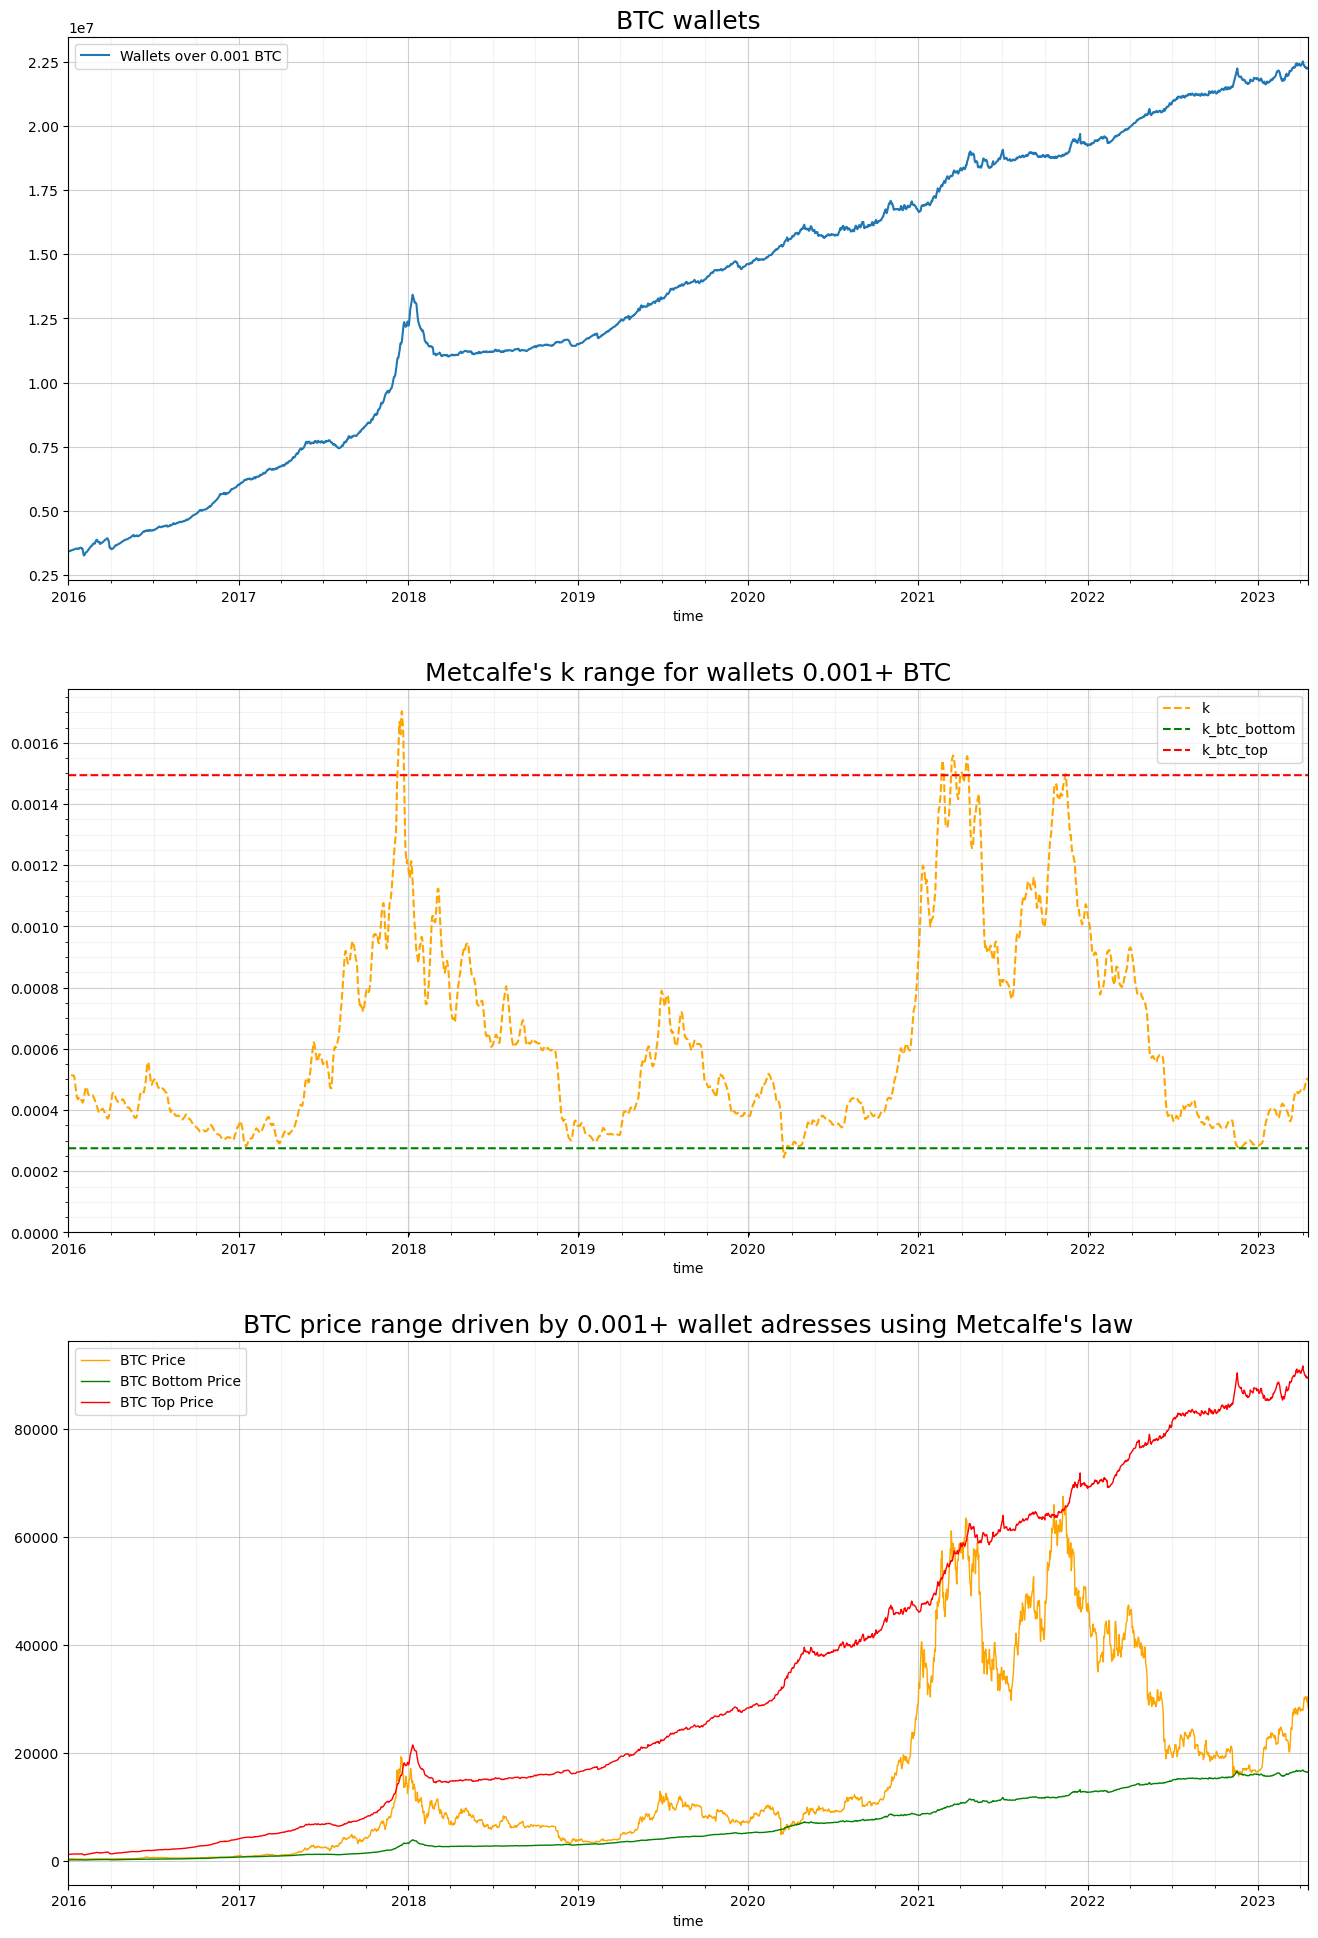

In [7]:
import matplotlib.pyplot as plt
today=df[df['BTC']['all']['price'] >0 ].index.max()
subplots = 1+len(min_btcs)*2;
fig, axs = plt.subplots(subplots)
fig.set_size_inches(16, 8*subplots)

axs[0].set_title("{} wallets".format(coin), fontsize=18)
for min_btc in min_btcs:
    df[coin][str(min_btc)+'+']['addressesCount'][:today].plot(ax=axs[0],label='Wallets over {} {}'.format(min_btc, coin) )
axs[0].legend(loc='best')
axs[0].grid(axis='both', which='major', alpha=0.6)
axs[0].grid(axis='both', which='minor', alpha=0.15)  
i=1
for min_btc in min_btcs:
#for i in range(1,subplots,2) :
    
    wallet_range = str(min_btc)+'+'
    axs[i].set_title("Metcalfe's k range for wallets {} {}".format(wallet_range, coin), fontsize=18)
    df[coin][wallet_range]['k-sma7d'][:today].plot(ax=axs[i],color='orange',label='k'.format(wallet_range, coin), linestyle='dashed')
    (df[coin][wallet_range]['k_btc_bottom'][:today]*btc_max_supply).plot(ax=axs[i],color='green',label='k_btc_bottom', linestyle='dashed')
    (df[coin][wallet_range]['k_btc_top'][:today]*btc_max_supply).plot(ax=axs[i],color='red',label='k_btc_top', linestyle='dashed')
    axs[i].legend(loc='best')
    axs[i].grid(which='major', alpha=0.6)
    axs[i].grid(which='minor', alpha=0.15)
    axs[i].minorticks_on()
    axs[i].set_ylim([0,None])

    axs[i+1].set_title("{} price range driven by {} wallet adresses using Metcalfe's law".format(coin, wallet_range), fontsize=18)

    #m2_adj_='m2_adj_'
    m2_adj_=''
    if 'm2_adj_'  == m2_adj_:
        m2_adj_text = "USD M2 Supply adjusted "
    else:
         m2_adj_text = ""
    df[coin]['all'][m2_adj_ + 'price'][:today].plot(ax=axs[i+1], linewidth=1, color='orange',label='{}{} Price'.format(m2_adj_text, coin))
    df[coin][wallet_range][m2_adj_ + 'bottom_price'][:today].plot(ax=axs[i+1], linewidth=1,color='green',label='{}{} Bottom Price'.format(m2_adj_text, coin)) 
    df[coin][wallet_range][m2_adj_ + 'top_price'][:today].plot(ax=axs[i+1], linewidth=1,color='red',label='{}{} Top Price'.format(m2_adj_text, coin)) 
    #axs[i+1].set_yscale('log')
    axs[i+1].legend(loc='best')
    axs[i+1].grid(which='major', alpha=0.6)
    axs[i+1].grid(which='minor', alpha=0.15)     
    i=i+2

In [8]:
import math
import numpy as np
from datetime import date
def linear_growth(n,p_0,k):
    return k*n
def quadratic_growth(n,p_0,k):
    return k*n*n
def n_log_n_growth(n,p_0,k):
    return k*n*np.log2(n)

def limited_growth_function_log(t,p_0,k,l):
    return np.log2(l*p_0/( (l-p_0)*(math.e ** (-k*t))+p_0))
def limited_growth_function(t,p_0,k,l):
    return l*p_0/( (l-p_0)*(math.e ** (-k*t))+p_0)
def limited_growth_function_log(t,p_0,k,l):
    return np.log2(l*p_0/( (l-p_0)*(math.e ** (-k*t))+p_0))

from scipy.optimize import curve_fit
#p_0 = 314.25
p_0 = 4300000000.0
t_0 = pd.Timestamp('2015-01-01')
k = 7445.7718443355325
l = 1*1000*1000*1000000

df.loc(axis=1)[('BTC','all','delta_days')] = (df.index-t_0).days
    

df

coin                    BTC                                          \
wallet_range       100000-0                      all             1+   
metrics      addressesCount    totalVolume     price addressesCount   
time                                                                  
2016-01-01                2  325228.141841    433.99         487725   
2016-01-02                2  325228.141841    433.72         488157   
2016-01-03                2  325228.141841    430.70         488369   
2016-01-04                2  325228.143333    433.32         488813   
2016-01-05                2  325228.143333    431.20         488080   
...                     ...            ...       ...            ...   
2023-04-16                4  673305.936238  30322.77         993903   
2023-04-17                4  673305.936351  29446.77         994057   
2023-04-18                4  673305.936351  30396.77         994038   
2023-04-19                4  673305.936351  28828.20         994034   
2023-04-20                4  673305.936351  28245.06         993907   

coin                                                            USD  \
wallet_range           0.1+          0.01+         0.001+       all   
metrics      addressesCount addressesCount addressesCount m2_supply   
time                                                                  
2016-01-01          1195665        2364920        3450821   12459.0   
2016-01-02          1199280        2341708        3429138   12459.0   
2016-01-03          1201885        2347196        3441312   12459.0   
2016-01-04          1205712        2355631        3452242   12459.0   
2016-01-05          1205145        2354711        3453441   12459.0   
...                     ...            ...            ...       ...   
2023-04-16          4307439       11737396       22249991   21123.3   
2023-04-17          4308633       11740939       22240718   21123.3   
2023-04-18          4310477       11743784       22224427   21123.3   
2023-04-19          4311945       11757195       22246255   21123.3   
2023-04-20          4313206       11770435       22264618   21123.3   

coin                                   BTC  ...                                \
wallet_range                           all  ...    0.001+                       
metrics      m2_supply_index  m2_adj_price  ...  k-sma90d k-sma180d k-sma365d   
time                                        ...                                 
2016-01-01          1.501175    289.100249  ...       NaN       NaN       NaN   
2016-01-02          1.501175    288.920390  ...       NaN       NaN       NaN   
2016-01-03          1.501175    286.908632  ...       NaN       NaN       NaN   
2016-01-04          1.501175    288.653932  ...       NaN       NaN       NaN   
2016-01-05          1.501175    287.241705  ...       NaN       NaN       NaN   
...                      ...           ...  ...       ...       ...       ...   
2023-04-16          2.545129  11914.039455  ...  0.000420  0.000364  0.000412   
2023-04-17          2.545129  11569.852609  ...  0.000422  0.000365  0.000412   
2023-04-18          2.545129  11943.114599  ...  0.000423  0.000366  0.000411   
2023-04-19          2.545129  11326.811904  ...  0.000425  0.000367  0.000410   
2023-04-20          2.545129  11097.691908  ...  0.000425  0.000367  0.000409   

coin                                                                        \
wallet_range                                                                 
metrics       k_btc_bottom m2_adj_bottom_price  bottom_price     k_btc_top   
time                                                                         
2016-01-01    1.310856e-11          156.098846    234.331650  7.116431e-11   
2016-01-02    1.310856e-11          154.143336    231.396087  7.116431e-11   
2016-01-03    1.310856e-11          155.239747    233.041992  7.116431e-11   
2016-01-04    1.310856e-11          156.227431    234.524678  7.116431e-11   
2016-01-05    1.310856e-11  

In [9]:
guess = [p_0, k]
today=df[df['BTC']['all']['price'] >0 ].index.max()
min_date = df.index.min()
ix = pd.date_range(start=min_date, end=date(2032, 4, 19), freq='D')
df = df.reindex(ix)
df.loc(axis=1)[('BTC','all','delta_days')] = (df.index-t_0).days
linear_fitting_start_date='2022-01-01'
print(today)

for min_btc in min_btcs:
    wallet_range = str(min_btc) + '+'
    parameters, covariance = curve_fit(linear_growth, df['BTC']['all']['delta_days'][linear_fitting_start_date:today], df['BTC'][wallet_range]['addressesCount'][linear_fitting_start_date:today],p0=guess)
    print("p_0={}, k={}, l={}".format(parameters[0],parameters[1],parameters[1]))
    df.loc(axis=1)[('BTC',wallet_range,'addressesCount_linear_guess')]= linear_growth((df.index-t_0).days,p_0,k)
    df.loc(axis=1)[('BTC',wallet_range,'addressesCount_linear_fit')]= linear_growth((df.index-t_0).days,parameters[0],parameters[1])

    df.loc(axis=1)[('BTC', wallet_range, 'm2_adj_bottom_price_linear_fit')] = \
        k_btc_bottom * df.loc(axis=1)[(coin,wallet_range,'addressesCount_linear_fit')]**2
    df.loc(axis=1)[('BTC', wallet_range, 'bottom_price_linear_fit')] = \
    df.loc(axis=1)[('BTC', wallet_range, 'm2_adj_bottom_price_linear_fit')]  * df.loc(axis=1)[('USD','all', 'm2_supply_index')][today]   

    df.loc(axis=1)[('BTC', wallet_range, 'm2_adj_top_price_linear_fit')] = \
        k_btc_top * df.loc(axis=1)[(coin,wallet_range,'addressesCount_linear_fit')]**2
    df.loc(axis=1)[('BTC', wallet_range, 'top_price_linear_fit')] = \
    df.loc(axis=1)[('BTC', wallet_range, 'm2_adj_top_price_linear_fit')]  * df.loc(axis=1)[('USD','all', 'm2_supply_index')][today]   
    
df


2023-04-20 00:00:00
p_0=4300000000.0, k=7518.208281944031, l=7518.208281944031


/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


coin                    BTC                                        \
wallet_range       100000-0                    all             1+   
metrics      addressesCount    totalVolume   price addressesCount   
2016-01-01              2.0  325228.141841  433.99       487725.0   
2016-01-02              2.0  325228.141841  433.72       488157.0   
2016-01-03              2.0  325228.141841  430.70       488369.0   
2016-01-04              2.0  325228.143333  433.32       488813.0   
2016-01-05              2.0  325228.143333  431.20       488080.0   
...                     ...            ...     ...            ...   
2032-04-15              NaN            NaN     NaN            NaN   
2032-04-16              NaN            NaN     NaN            NaN   
2032-04-17              NaN            NaN     NaN            NaN   
2032-04-18              NaN            NaN     NaN            NaN   
2032-04-19              NaN            NaN     NaN            NaN   

coin                                                            USD  \
wallet_range           0.1+          0.01+         0.001+       all   
metrics      addressesCount addressesCount addressesCount m2_supply   
2016-01-01        1195665.0      2364920.0      3450821.0   12459.0   
2016-01-02        1199280.0      2341708.0      3429138.0   12459.0   
2016-01-03        1201885.0      2347196.0      3441312.0   12459.0   
2016-01-04        1205712.0      2355631.0      3452242.0   12459.0   
2016-01-05        1205145.0      2354711.0      3453441.0   12459.0   
...                     ...            ...            ...       ...   
2032-04-15              NaN            NaN            NaN       NaN   
2032-04-16              NaN            NaN            NaN       NaN   
2032-04-17              NaN            NaN            NaN       NaN   
2032-04-18              NaN            NaN            NaN       NaN   
2032-04-19              NaN            NaN            NaN       NaN   

coin                                  BTC  ...                                 \
wallet_range                          all  ...        0.001+                    
metrics      m2_supply_index m2_adj_price  ...     k_btc_top m2_adj_top_price   
2016-01-01          1.501175   289.100249  ...  7.116431e-11       847.436393   
2016-01-02          1.501175   288.920390  ...  7.116431e-11       836.820233   
2016-01-03          1.501175   286.908632  ...  7.116431e-11       842.772477   
2016-01-04          1.501175   288.653932  ...  7.116431e-11       848.134462   
2016-01-05          1.501175   287.241705  ...  7.116431e-11       848.723696   
...                      ...          ...  ...           ...              ...   
2032-04-15               NaN          NaN  ...           NaN              NaN   
2032-04-16               NaN          NaN  ...           NaN              NaN   
2032-04-17               NaN          NaN  ...           NaN              NaN   
2032-04-18               NaN          NaN  ...           NaN              NaN   
2032-04-19               NaN          NaN  ...           NaN              NaN   

coin                                                              \
wallet_range                     all                      0.001+   
metrics         top_price delta_days addressesCount_linear_guess   
2016-01-01    1272.150132        365                2.717707e+06   
2016-01-02    1256.213420        366                2.725152e+06   
2016-01-03    1265.148779        367                2.732598e+06   
2016-01-04    1273.198055        368                2.740044e+06   
2016-01-05    1274.082599        369                2.747490e+06   
...                   ...        ...                         ...   
2032-04-15            NaN       6314                4.701260e+07   
2032-04-16            NaN       6315                4.702005e+07   
2032-04-17            NaN       6316                4.702749e+07   
2032-04-18            NaN       6317                4.703494e+07   
2032-04-19         

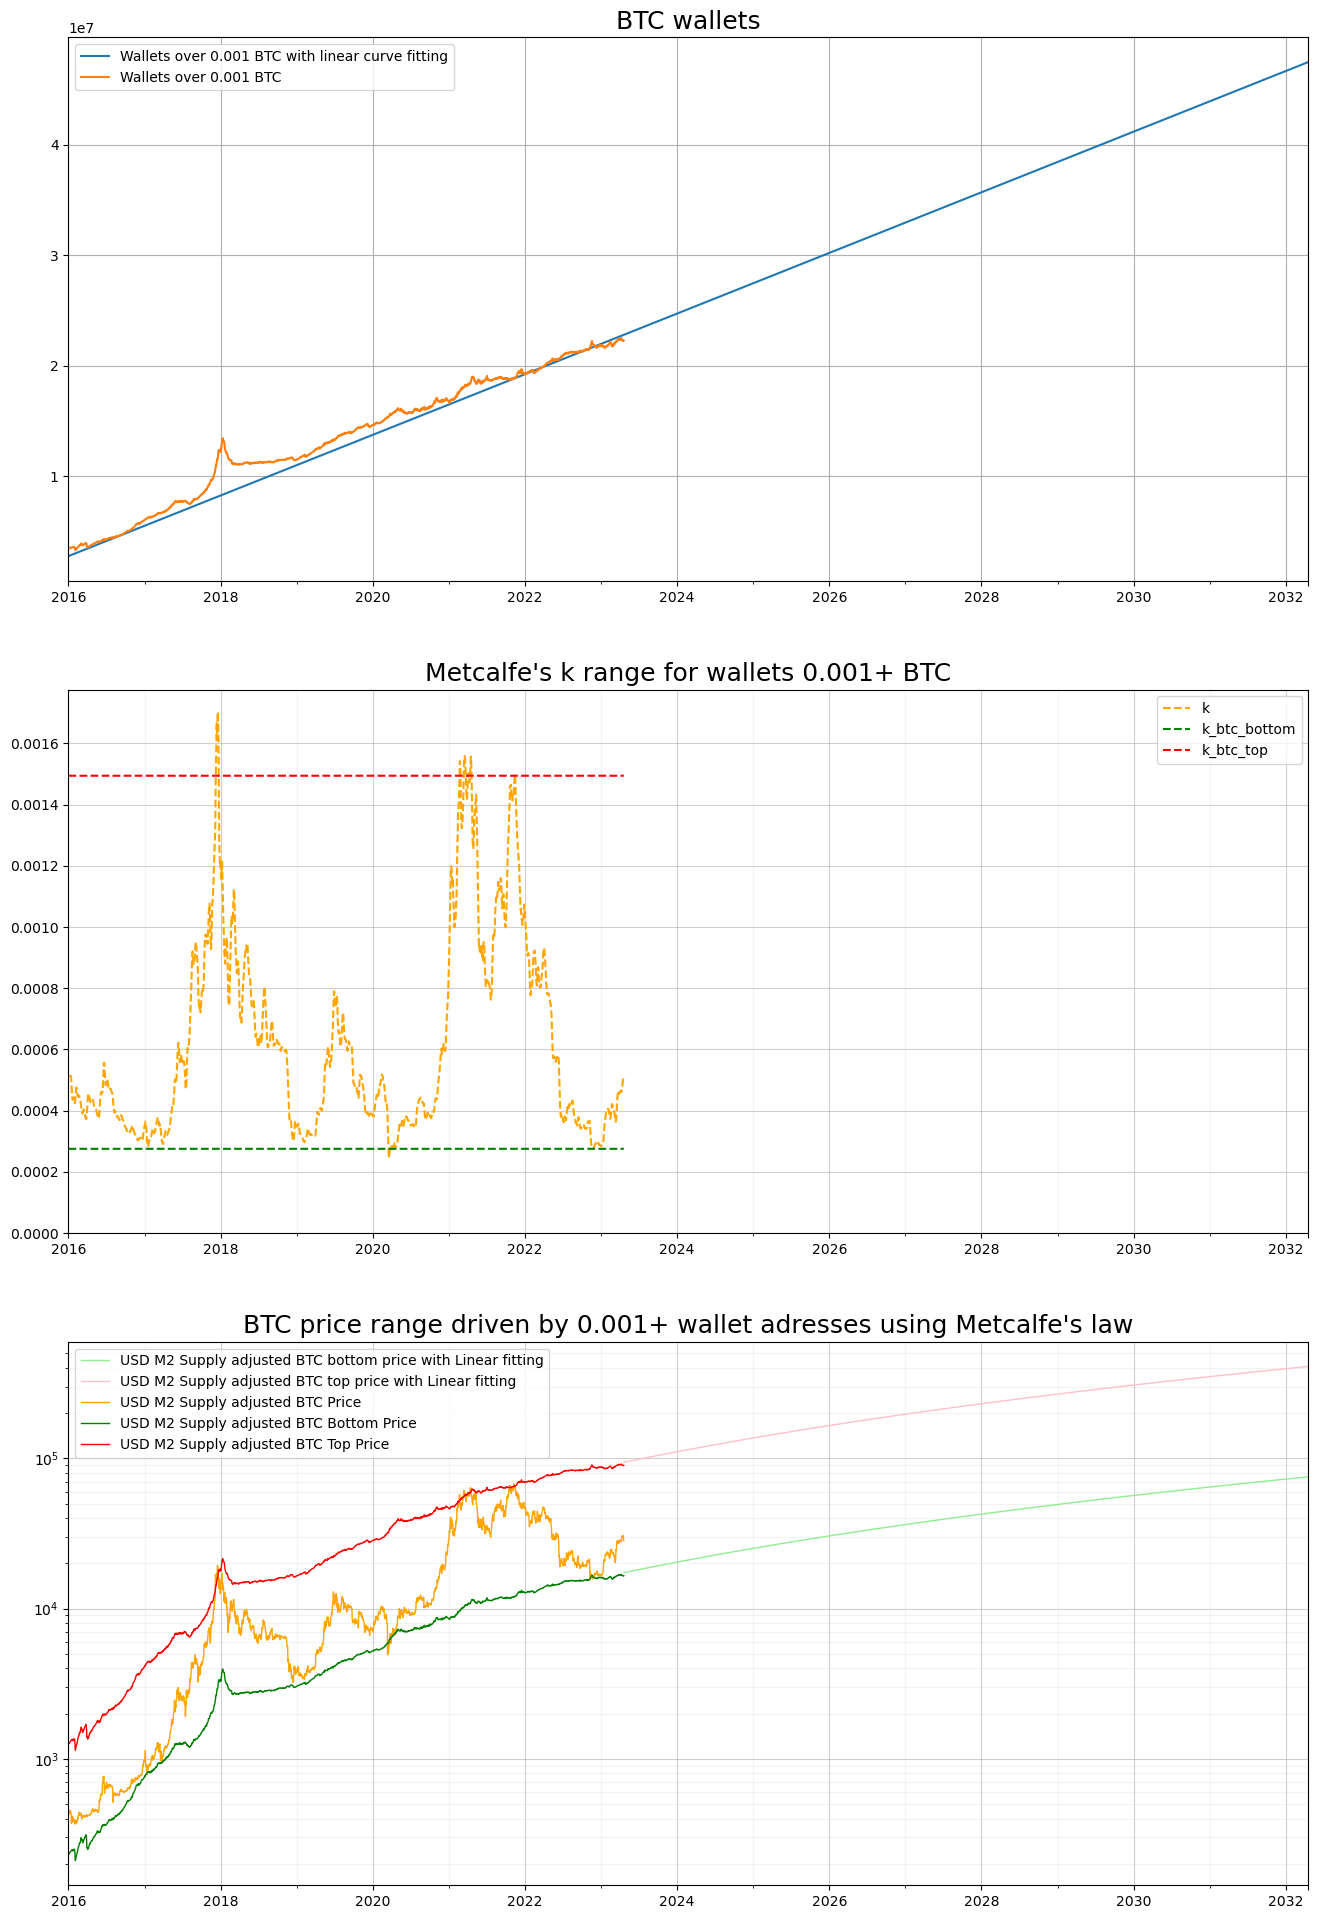

In [10]:
import matplotlib.pyplot as plt
subplots = 1+len(min_btcs)*2;
fig, axs = plt.subplots(subplots)
fig.set_size_inches(16, 8*subplots)

axs[0].set_title("{} wallets".format(coin), fontsize=18)
for min_btc in min_btcs:
    df[coin][str(min_btc)+'+']['addressesCount_linear_fit'].plot(ax=axs[0],label='Wallets over {} {} with linear curve fitting'.format(min_btc, coin) )
#    df[coin][str(min_btc)+'+']['addressesCount_linear_guess'].plot(ax=axs[0],label='Wallets over {} {} with linear guess'.format(min_btc, coin) )
    df[coin][str(min_btc)+'+']['addressesCount'].plot(ax=axs[0],label='Wallets over {} {}'.format(min_btc, coin) )
axs[0].legend(loc='best')
axs[0].grid()
i=1
for min_btc in min_btcs:
#for i in range(1,subplots,2) :
    
    wallet_range = str(min_btc)+'+'
    axs[i].set_title("Metcalfe's k range for wallets {} {}".format(wallet_range, coin), fontsize=18)
    df[coin][wallet_range]['k-sma7d'].plot(ax=axs[i],color='orange',label='k'.format(wallet_range, coin), linestyle='dashed')
    (df[coin][wallet_range]['k_btc_bottom']*btc_max_supply).plot(ax=axs[i],color='green',label='k_btc_bottom', linestyle='dashed')
    (df[coin][wallet_range]['k_btc_top']*btc_max_supply).plot(ax=axs[i],color='red',label='k_btc_top', linestyle='dashed')
    axs[i].legend(loc='best')
    axs[i].set_ylim([0,None])
    axs[i].grid(which='major', alpha=0.6)
    axs[i].grid(which='minor', alpha=0.15) 
    axs[i+1].set_title("{} price range driven by {} wallet adresses using Metcalfe's law".format(coin, wallet_range), fontsize=18)

    #m2_adj_='m2_adj_'
    m2_adj_=''
    wallet_range
    df[coin][wallet_range][m2_adj_ + 'bottom_price_linear_fit'][today:].plot(ax=axs[i+1], linewidth=1, color='lightgreen',label='USD M2 Supply adjusted {} bottom price with Linear fitting'.format(coin))
    df[coin][wallet_range][m2_adj_ + 'top_price_linear_fit'][today:].plot(ax=axs[i+1], linewidth=1, color='pink',label='USD M2 Supply adjusted {} top price with Linear fitting'.format(coin))

    df[coin]['all'][m2_adj_ + 'price'].plot(ax=axs[i+1], linewidth=1, color='orange',label='USD M2 Supply adjusted {} Price '.format(coin))

    df[coin][wallet_range][m2_adj_ + 'bottom_price'].plot(ax=axs[i+1], linewidth=1,color='green',label='USD M2 Supply adjusted {} Bottom Price'.format(coin)) 
    df[coin][wallet_range][m2_adj_ + 'top_price'].plot(ax=axs[i+1], linewidth=1,color='red',label='USD M2 Supply adjusted {} Top Price'.format(coin)) 
    axs[i+1].set_yscale('log')
    axs[i+1].legend(loc='best')
    axs[i+1].grid(which='major', alpha=0.6)
    axs[i+1].grid(which='minor', alpha=0.15) 
    i=i+2